######Google Drive and import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge2/

/gdrive/MyDrive/Challenge2


In [ ]:
#!unzip training_dataset_homework2

Archive:  training_dataset_homework2.zip
  inflating: y_train.npy             
  inflating: x_train.npy             


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

# Random seed for reproducibility
seed = 127

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Data loading and inspection

In [ ]:
X = np.load("x_train.npy")
y = np.load("y_train.npy")
print(X.shape,y.shape)

(2429, 36, 6) (2429,)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


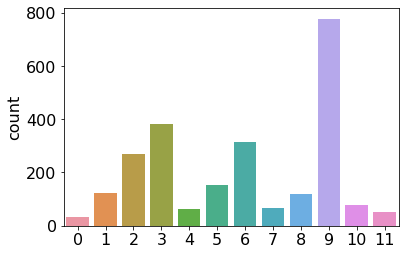

In [ ]:
#Unbalance in the data
sns.countplot(y)

In [ ]:
#Split into train-validation (our test) set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)

In [ ]:
#Split into train-validation (our test) set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
from sklearn.utils import class_weight
cws = class_weight.compute_class_weight(class_weight = "balanced" , classes = np.unique(y_train), y= y_train)

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

######normalize/standardize data (eventually)

normalize each time series

In [ ]:
# means = np.array([[np.mean(X_train[:,:,i].reshape(2064*36))] for i in range(6)])
# stds = np.array([[np.std(X_train[:,:,i].reshape(2064*36))] for i in range(6)])
# means2 = np.array([[np.mean(X_val[:,:,i].reshape(365*36))] for i in range(6)])
# stds2 = np.array([[np.std(X_val[:,:,i].reshape(365*36))] for i in range(6)])
# means,stds

In [ ]:
# X_train[0,:,0].std(),X_train[0,:,0].mean()

(18.707681227483285, 5.523425)

In [ ]:
# #normalize each time series
# for i in range(6):
#   for j in range(len(X_train[:,0,0])):
#     X_train[j,:,i] = (X_train[j,:,i] - X_train[j,:,i].mean())/X_train[j,:,i].std()

In [ ]:
# for i in range(6):
#   for j in range(len(X_val[:,0,0])):
#     X_val[j,:,i] = (X_val[j,:,i] - X_val[j,:,i].mean())/X_val[j,:,i].std()

In [ ]:
# X_train[0,:,0].std(),X_train[0,:,0].mean()

(1.0, 1.0793834961633467e-17)

normalize all time series

In [ ]:
# means = np.array([[np.max(X_train[:,:,i].reshape(2064*36))] for i in range(6)])
# stds = np.array([[np.min(X_train[:,:,i].reshape(2064*36))] for i in range(6)])
# means2 = np.array([[np.max(X_val[:,:,i].reshape(365*36))] for i in range(6)])
# stds2 = np.array([[np.min(X_val[:,:,i].reshape(365*36))] for i in range(6)])
# means,stds

In [ ]:
# #Normalize all
# for i in range(6):
#   X_train[:,:,i] = (X_train[:,:,i] - means[i]) / stds[i]
#   X_val[:,:,i] = (X_val[:,:,i] - means2[i]) / stds2[i]

minmax scaler

In [ ]:
# X_train = X_train.reshape(2064*36,6)
# X_val = X_val.reshape(365*36,6)
# scaler = MinMaxScaler()
# scaler = scaler.fit(X_train)
# scaler2 = scaler.fit(X_val)

# X_train = scaler.transform(X_train).reshape(2064,36,6)
# X_val = scaler2.transform(X_val).reshape(365,36,6)

#### Building Neural Network models

In [ ]:
input_shape = X.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 200

In [ ]:
input_shape,classes

((36, 6), 12)

#####1st model: BiLSTM

In [ ]:
#Validation
# Accuracy: 0.6502
# Precision: 0.5298
# Recall: 0.4797
# F1: 0.4858
def build_BiLSTM_classifier(input_shape, classes): #68% val, 62% mio test
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.AveragePooling1D()(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.3, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 36, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               8320  

#####2nd model: LSTM

In [ ]:
# Accuracy: 0.6626
# Precision: 0.5647
# Recall: 0.5479
# F1: 0.548
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128,return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.2, seed=seed)(lstm)

    # Classifier

    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.2, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Accuracy: 0.6626
# Precision: 0.5647
# Recall: 0.5479
# F1: 0.548
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, dropout = 0.2, recurrent_dropout = 0.2,return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128, dropout = 0.2, recurrent_dropout = 0.2)(lstm)
    dropout = tfkl.Dropout(.2, seed=seed)(lstm)

    # Classifier

    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.2, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512 

#####3rd model: CNN

In [ ]:
# Accuracy: 0.7449
# Precision: 0.7555
# Recall: 0.6735
# F1: 0.6961
def build_1DCNN_classifier(input_shape, classes):#70% test set X_val con 0.1 val split su X-train
#69% con data augm sia val che test
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.AveragePooling1D()(cnn)# 
    cnn = tfkl.Conv1D(256,3,padding='valid',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Accuracy: 0.7449
# Precision: 0.7555
# Recall: 0.6735
# F1: 0.6961
def build_1DCNN_classifier(input_shape, classes):#70% test set X_val con 0.1 val split su X-train
#69% con data augm sia val che test
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.AveragePooling1D()(cnn)# 
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Accuracy: 0.6749
# Precision: 0.6903
# Recall: 0.4914
# F1: 0.5303
#68% sia val che test con data augm prob = 0.7, time warp, magnitude warp, scaler
def build_1DCNN_classifier2(input_shape, classes):#68%val, 67-70%% sul test set X_val #67% hidden test set
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(16,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(32,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(cnn)

    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_1DCNN_classifier3(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(256,3,dilation_rate = 2,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 average_pooling1d_1 (Averag  (None, 18, 128)          0         
 ePooling1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 256)           98560     
                                                                 
 global_average_pooling1d_1   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 256)               0     

#####4th model: CNN + BiLSTM

In [ ]:
#Validation
# Accuracy: 0.6955
# Precision: 0.6901
# Recall: 0.6331
# F1: 0.6516
def build_CONV_LSTM_model(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Conv1D(32, 3, padding='same', activation='relu')(input_layer)
    convlstm = tfkl.Conv1D(64, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128))(convlstm)

    convlstm = tfkl.Dropout(.2)(convlstm)

    convlstm = tfkl.Dense(64, activation='relu')(convlstm)

    convlstm = tfkl.Dropout(.2, seed=seed)(convlstm)

    convlstm = tfkl.Dense(64, activation='relu')(convlstm)

    output_layer = tfkl.Dense(classes, activation='softmax')(convlstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model    


In [ ]:
model = build_CONV_LSTM_model(input_shape=input_shape, classes = 12)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 36, 128)           2432      
                                                                 
 conv1d_25 (Conv1D)          (None, 36, 256)           98560     
                                                                 
 lstm_14 (LSTM)              (None, 36, 128)           197120    
                                                                 
 lstm_15 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256  

####Train

#####Vanilla Train

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 300,
    validation_data= (X_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=70, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=30, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/300
61/61 [==============================] - 22s 263ms/step - loss: 1.9189 - accuracy: 0.3793 - val_loss: 1.6062 - val_accuracy: 0.4362 - lr: 0.0010
Epoch 2/300
61/61 [==============================] - 16s 257ms/step - loss: 1.4691 - accuracy: 0.4771 - val_loss: 1.4244 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 3/300
61/61 [==============================] - 16s 260ms/step - loss: 1.3123 - accuracy: 0.5353 - val_loss: 1.2871 - val_accuracy: 0.5576 - lr: 0.0010
Epoch 4/300
61/61 [==============================] - 16s 261ms/step - loss: 1.2341 - accuracy: 0.5703 - val_loss: 1.1972 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 5/300
61/61 [==============================] - 16s 257ms/step - loss: 1.1684 - accuracy: 0.5929 - val_loss: 1.2628 - val_accuracy: 0.6008 - lr: 0.0010
Epoch 6/300
61/61 [==============================] - 16s 267ms/step - loss: 1.1209 - accuracy: 0.6073 - val_loss: 1.2159 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 7/300
61/61 [==============================] - 16s 2

#####Train with Class Weights

In [ ]:
weights = {i : cws[i] for i in range(12)}

In [ ]:
#lower weights
for i in range(12):
  weights[i]=1
  if(i!=2 and i!= 3 and i!= 6 and i!=9):
    weights[i]=2


In [ ]:
weights

{0: 2, 1: 2, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 1, 10: 2, 11: 2}

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val,y_val),
    class_weight = weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

#####Train with Data Augmentation/ "synthetic data from noise" (it's more like jittering)

######Data Augmentation

In [ ]:
def window_slice(x, reduce_ratio=0.9):
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def magnitude_warp(x, sigma=0.2, knot=3):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

def time_warp(x, sigma=0.1, knot=1):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def jitter(x, sigma=1):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

In [ ]:
def select_random_transformations(x, prob = 0.7):
    if(np.random.binomial(1, prob, size=None)==1):
        x = scaling(x)
    if(np.random.binomial(1, prob, size=None)==1):
        x = time_warp(x)
    if(np.random.binomial(1, prob, size=None)==1):
        x = magnitude_warp(x)

    return x    

In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.15, random_state=seed+1)

x_aug1 = X_train2.copy()
y_aug1 = y_train2.copy()

In [ ]:
#Create new data for training to augment the worst classes (proportional to class weigths)
for i in range(12):
    
    #if i==4 or i==5 or i ==7:
    #if i!=9:

        #consider the class i samples and make j times new augmented data
        x_temp = X_train2[np.where(y_train2==i)[0],:,:]

        for j in range(int(cws[i])):
            x_temp = select_random_transformations(x_temp)
            

            x_aug1 = np.append(x_aug1, x_temp, axis=0)
            #append the labels of the class i
            y_aug1 = np.append(y_aug1,np.array([[i] for k in range(len(x_temp[:,0,0]))]))

In [ ]:
# Convert the sparse labels to categorical values
y_val2 = tfk.utils.to_categorical(y_val2)
y_aug1 = tfk.utils.to_categorical(y_aug1)

######Synthetic dataset

In [ ]:
def create_from_noise(x):
    
    new_x = x.copy()

    for i in range(6):
        for j in range(len(x[:,0,0])):
            mean = x[j,:,i].mean()
            std = x[j,:,i].std()
            noise = x[j,:,i] - mean - std
            noise_mean = noise.mean()
            new_x[j,:,i] = x[j,:,i] + 0.2*np.random.normal(loc=0, scale=abs(noise_mean), size=x[j,:,i].shape) 

    return new_x

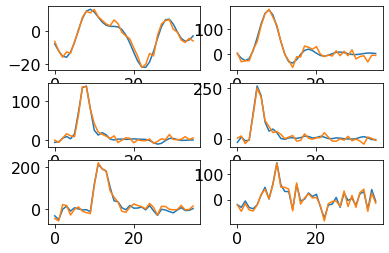

In [ ]:
fig, ax = plt.subplots(nrows=3,ncols=2)
i = 0
for row in ax:
    for col in row:
        col.plot(X[2000,:,i])
        col.plot(create_from_noise(X)[2000,:,i])
        i+=1


In [ ]:
x_aug = X.copy()
y_aug = y.copy()

In [ ]:
x_aug, X_val_aug, y_aug, y_val_aug = train_test_split(x_aug, y_aug, test_size=0.2, random_state=seed)

In [ ]:
#Create new data from noise for training and validation (since the are very few samples for some classes)
for i in range(12):
    
    if i==0 or i==4 or i==11:
    #if i!=9 and i!=2 and i!=3 and i!=6 :

        #consider the class i samples and make j times new augmented data
        x_temp = x_aug[np.where(y_aug==i)[0],:,:]

        for j in range(1):
            x_temp = create_from_noise(x_temp)
            

            x_aug = np.append(x_aug, x_temp, axis=0)
            #append the labels of the class i
            y_aug = np.append(y_aug,np.array([[i] for k in range(len(x_temp[:,0,0]))]))

In [ ]:
x_aug.shape,y_aug.shape

((2068, 36, 6), (2068,))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


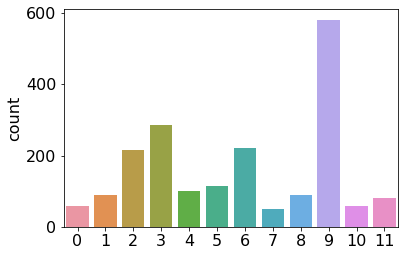

In [ ]:
sns.countplot(y_aug)

In [ ]:
# Convert the sparse labels to categorical values
y_aug = tfk.utils.to_categorical(y_aug)
y_val_aug = tfk.utils.to_categorical(y_val_aug)

In [ ]:
# Train the model
history = model.fit(
    x = x_aug,
    y = y_aug,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val_aug, y_val_aug),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

19/19 [==============================] - 0s 6ms/step
Accuracy: 0.7171
Precision: 0.6975
Recall: 0.6268
F1: 0.6479


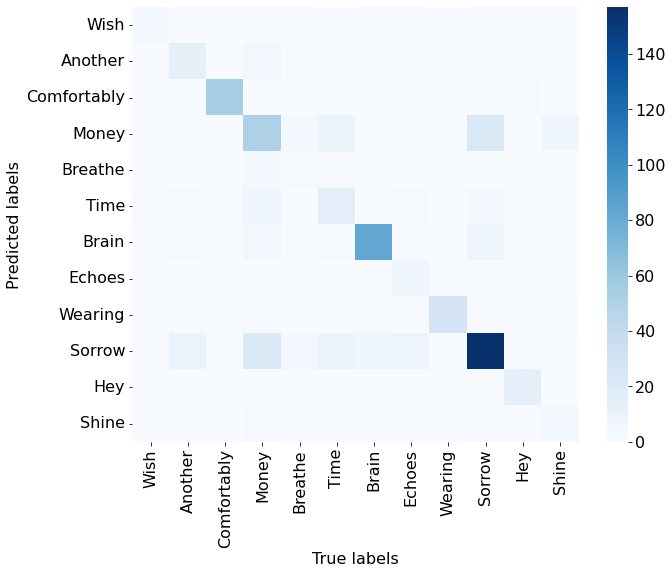

In [ ]:
# Compute the confusion matrix on the validation set
predictions = model.predict(X_val_aug)
cm = confusion_matrix(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# model.save("cnn_synth_7265")

In [ ]:
# model.save("CNN3_data_augm_13_12")

####History and Confusion Matrix

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the val set with the BiLSTM
predictions = model.predict(X_val)

16/16 [==============================] - 1s 21ms/step


In [ ]:
# Map activities to integers
label_mapping = {
0: "Wish",
1: "Another",
2: "Comfortably",
3: "Money",
4: "Breathe",
5: "Time",
6: "Brain",
7: "Echoes",
8: "Wearing",
9: "Sorrow",
10: "Hey",
11: "Shine"}

Accuracy: 0.7305
Precision: 0.695
Recall: 0.603
F1: 0.6342


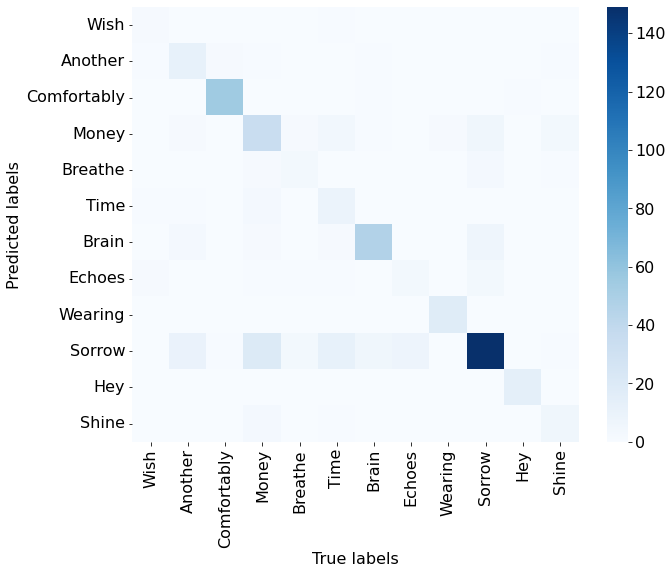

In [ ]:
# Compute the confusion matrix on the validation set
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy: 0.7449
Precision: 0.7555
Recall: 0.6735
F1: 0.6961


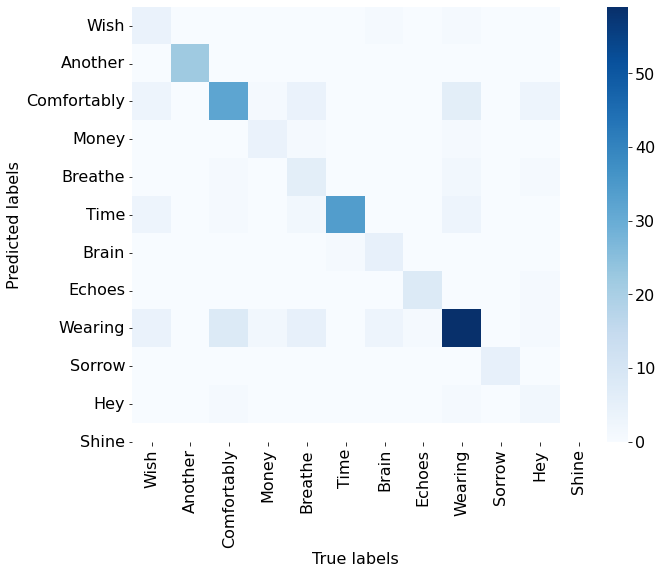

In [ ]:
# Compute the confusion matrix on the validation set
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

####Break Sequences (not good)

In [ ]:
X = np.load("x_train.npy")
y = np.load("y_train.npy")
print(X.shape,y.shape)

(2429, 36, 6) (2429,)


In [ ]:
X_train_break, X_val_break, y_train_break, y_val_break = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
X_train_break.shape

(1943, 36, 6)

In [ ]:
#Break sequences in half
x_break = X_train_break.copy()
y_break = y_train_break.copy()
X_break = x_break[0,:18,:]
X_break = np.append(X_break,x_break[0,18:,:],axis=0)
X_break = X_break.reshape(2,18,6)
Y_break = y_break[0]
Y_break = np.append(Y_break,y_break[0])

In [ ]:
X_break.shape,Y_break.shape

((2, 18, 6), (2,))

In [ ]:
for i in range(len(x_break[:,0,0])-1):
  i+=1
  x_new = x_break[i,18:,:]
  x_old = x_break[i,:18,:]
  X_break = np.append(X_break,x_new)
  Y_break = np.append(Y_break,y_break[i])
  X_break = np.append(X_break,x_new)
  Y_break = np.append(Y_break,y_break[i])

In [ ]:
X_break.shape

(419688,)

In [ ]:
X_break = X_break.reshape(1943*2,18,6)
X_break.shape,Y_break.shape

((3886, 18, 6), (3886,))

In [ ]:
# Convert the sparse labels to categorical values
Y_break = tfk.utils.to_categorical(Y_break)


In [ ]:
model = build_1DCNN_classifier((18,6), classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 18, 6)]           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 18, 128)           2432      
                                                                 
 average_pooling1d_5 (Averag  (None, 9, 128)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_18 (Conv1D)          (None, 9, 256)            98560     
                                                                 
 global_average_pooling1d_8   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 256)               0     

In [ ]:
#Break sequences in half
x_break = X_val_break.copy()
y_break = y_val_break.copy()
X_break_val = x_break[0,:18,:]
X_break_val = np.append(X_break_val,x_break[0,18:,:],axis=0)
X_break_val = X_break_val.reshape(2,18,6)
Y_break_val = y_break[0]
Y_break_val = np.append(Y_break_val,y_break[0])

In [ ]:
for i in range(len(x_break[:,0,0])-1):
  i+=1
  x_new = x_break[i,18:,:]
  x_old = x_break[i,:18,:]
  X_break_val = np.append(X_break_val,x_new)
  Y_break_val = np.append(Y_break_val,y_break[i])
  X_break_val = np.append(X_break_val,x_new)
  Y_break_val = np.append(Y_break_val,y_break[i])

In [ ]:
X_break_val = X_break_val.reshape(486*2,18,6)
X_break_val.shape,Y_break_val.shape

((972, 18, 6), (972,))

In [ ]:
Y_break_val = tfk.utils.to_categorical(Y_break_val)

In [ ]:
# Train the model
history = model.fit(
    x = X_break,
    y = Y_break,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_break_val,Y_break_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

Epoch 1/300
122/122 [==============================] - 5s 25ms/step - loss: 8.9096 - accuracy: 0.1969 - val_loss: 4.3942 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 2/300
122/122 [==============================] - 2s 19ms/step - loss: 4.7142 - accuracy: 0.2856 - val_loss: 2.4996 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 3/300
122/122 [==============================] - 2s 13ms/step - loss: 2.4763 - accuracy: 0.3603 - val_loss: 2.0626 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 4/300
122/122 [==============================] - 1s 11ms/step - loss: 2.1025 - accuracy: 0.3847 - val_loss: 1.9128 - val_accuracy: 0.3971 - lr: 0.0010
Epoch 5/300
122/122 [==============================] - 1s 11ms/step - loss: 2.3305 - accuracy: 0.3824 - val_loss: 1.8964 - val_accuracy: 0.3827 - lr: 0.0010
Epoch 6/300
122/122 [==============================] - 1s 12ms/step - loss: 2.0152 - accuracy: 0.3881 - val_loss: 1.7958 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 7/300
122/122 [==============================] - 1s 

In [ ]:
# Predict the val set with the BiLSTM
predictions1 = model.predict(X_break_val)

31/31 [==============================] - 13s 4ms/step


In [ ]:
accuracy = accuracy_score(np.argmax(Y_break_val, axis=-1), np.argmax(predictions1, axis=-1))

In [ ]:
accuracy

0.565843621399177

####Ensemble Model

#####Stacking and averaging different models: cnn + convlstm

In [ ]:
#Load Models
cnn =  tfk.models.load_model('CNN_3')
lstm_class_weights = tfk.models.load_model('LSTM_12_12')
bilstm = tfk.models.load_model('BiLSTM_12-12')
convlstm = tfk.models.load_model('CONVLSTM_12_12B')
# cnn_augm = tfk.models.load_model('BiLSTM_1')

In [ ]:
cnn._name = "cnn"
lstm_class_weights._name = "lstm_class_weights"
bilstm._name = "bilstm"
convlstm._name = "convlstm"
# cnn_augm._name = "cnn_augm"

In [ ]:
#all on the same dataset
models1 = []

models1.append(cnn)
# models1.append(lstm_class_weights)
# models1.append(bilstm)
models1.append(convlstm)
# models1.append(cnn_augm)

In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=tfk.layers.average(yModels) 
    # build model from same input and avg output
    modelEns = tfk.Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [ ]:
model_input = tfk.Input(shape=models1[0].input_shape[1:]) 
modelEns = ensembleModels(models1, model_input)
modelEns.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
modelEns.summary()

####3 CNNs + CONV_LSTM, trained on synthetic data

In [ ]:
#Split into train-validation (our test) set
X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.2, random_state=seed)
#Split into train-validation (our test) set
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.2, random_state=seed*2)
#Split into train-validation (our test) set
X_train3, X_val3, y_train3, y_val3 = train_test_split(X, y, test_size=0.2, random_state=seed*3)
#Split into train-validation (our test) set
X_train4, X_val4, y_train4, y_val4 = train_test_split(X, y, test_size=0.2, random_state=seed*4)

In [ ]:
x_9 = X.copy()
y_9 = y.copy()

In [ ]:
idx_no_9 = np.where(y_9!=9)[0]
idx_9 = np.where(y_9==9)[0]
idx_9 = idx_9[:int(len(idx_9)/2)]

In [ ]:
X_9 =x_9[np.append(idx_9,idx_no_9),:,:]
y_9 = y_9[np.append(idx_9,idx_no_9)]

In [ ]:
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_9, y_9, test_size=0.2, random_state=seed*4)

In [ ]:
y_train4 = tfk.utils.to_categorical(y_train4)
y_val4 = tfk.utils.to_categorical(y_val4)
y_train3 = tfk.utils.to_categorical(y_train3)
y_val3 = tfk.utils.to_categorical(y_val3)
y_train2 = tfk.utils.to_categorical(y_train2)
y_val2 = tfk.utils.to_categorical(y_val2)
y_train1 = tfk.utils.to_categorical(y_train1)
y_val1 = tfk.utils.to_categorical(y_val1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


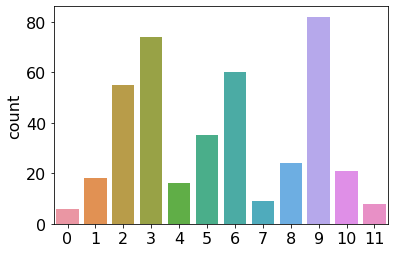

In [ ]:
sns.countplot(np.argmax(y_val4,axis=1))

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(256,3,dilation_rate = 2,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
cnnbest_dil_cws = build_1DCNN_classifier(input_shape, classes)

In [ ]:
for i in range(12):
  weights[i]=1
  if(i!=2 and i!= 3 and i!= 6 and i!=9):
    weights[i]=2

In [ ]:
# Train the model
history = cnnbest_dil_cws.fit(
    x = X_train4,
    y = y_train4,
    batch_size = batch_size,
    epochs = 300,
    class_weight = weights,
    validation_data = (X_val4, y_val4),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

16/16 [==============================] - 0s 6ms/step
Accuracy: 0.7119
Precision: 0.6673
Recall: 0.6084
F1: 0.6292


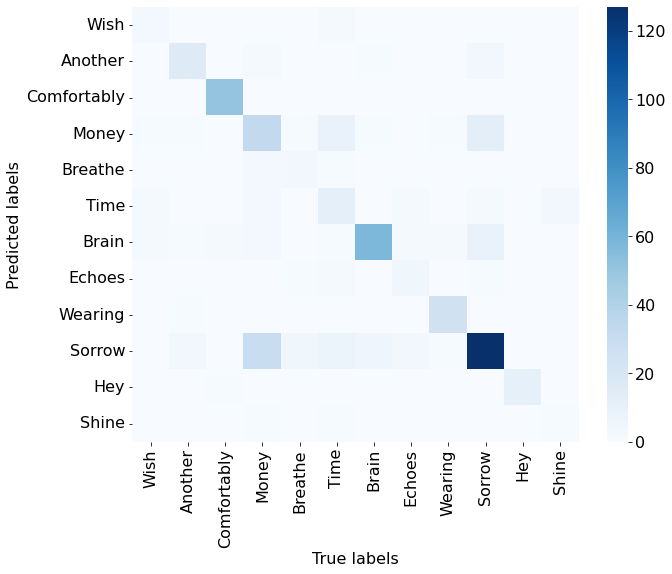

In [ ]:
# Compute the confusion matrix on the validation set
predictions = cnnbest_dil_cws.predict(X_val4)
cm = confusion_matrix(np.argmax(y_val4, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val4, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val4, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val4, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val4, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
cnnbest_dil_cws.save("cnnbest_dil_cws7163")

In [ ]:
def build_1DCNN_classifier2(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(16,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(32,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(cnn)

    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_CONV_LSTM_model(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Conv1D(32, 3, padding='same', activation='relu')(input_layer)
    convlstm = tfkl.Conv1D(64, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128))(convlstm)

    convlstm = tfkl.Dropout(.2)(convlstm)

    convlstm = tfkl.Dense(64, activation='relu')(convlstm)

    convlstm = tfkl.Dropout(.2, seed=seed)(convlstm)

    convlstm = tfkl.Dense(64, activation='relu')(convlstm)

    output_layer = tfkl.Dense(classes, activation='softmax')(convlstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model    


In [ ]:
convlstm = build_CONV_LSTM_model(input_shape, classes)

In [ ]:
# Train the model
history = convlstm.fit(
    x = X_train2,
    y = y_train2,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val2, y_val2),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-4)
    ]
).history

In [ ]:
# Train the model
# cnn_low_filters_synth = build_1DCNN_classifier2(input_shape, classes)
convlstm_synth = build_CONV_LSTM_model(input_shape, classes)
history = convlstm_synth.fit(
    x = x_aug,
    y = y_aug,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val_aug, y_val_aug),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-4)
    ]
).history

19/19 [==============================] - 3s 86ms/step
Accuracy: 0.6891
Precision: 0.6599
Recall: 0.5797
F1: 0.5957


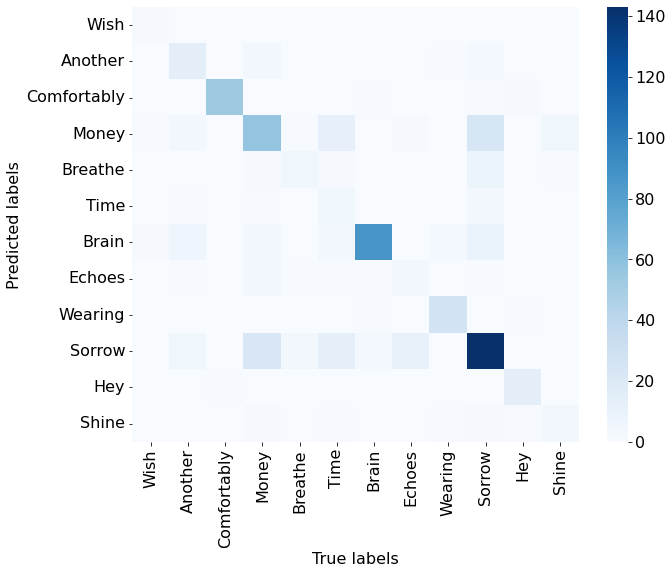

In [ ]:
# Compute the confusion matrix on the validation set
predictions = convlstm_synth.predict(X_val_aug)
cm = confusion_matrix(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

19/19 [==============================] - 0s 3ms/step
Accuracy: 0.7105
Precision: 0.7322
Recall: 0.5863
F1: 0.6179


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


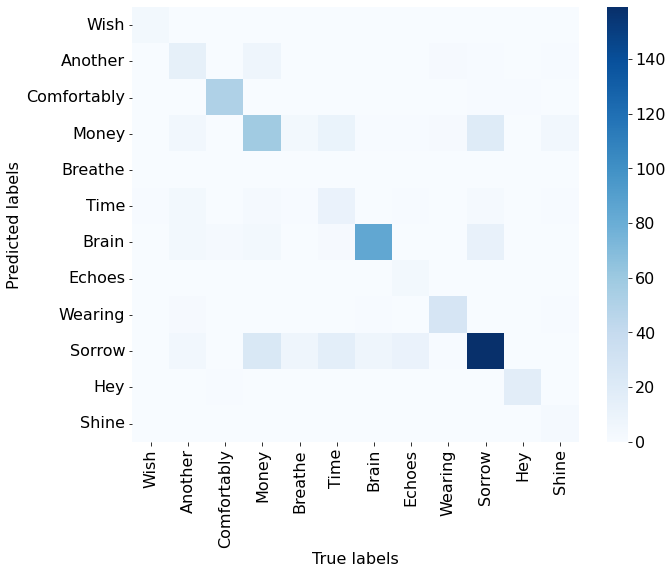

In [ ]:
# Compute the confusion matrix on the validation set
predictions = cnn_low_filters_synth.predict(X_val_aug)
cm = confusion_matrix(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
x_aug = X.copy()
y_aug = y.copy()
x_aug, X_val_aug, y_aug, y_val_aug = train_test_split(x_aug, y_aug, test_size=0.2, random_state=seed*2)
#Create new data from noise for training and validation (since the are very few samples for some classes)
for i in range(12):
    
    if i==0 or i==4 or i==11:
    #if i!=9 and i!=2 and i!=3 and i!=6 :

        #consider the class i samples and make j times new augmented data
        x_temp = x_aug[np.where(y_aug==i)[0],:,:]

        for j in range(1):
            x_temp = create_from_noise(x_temp)
            

            x_aug = np.append(x_aug, x_temp, axis=0)
            #append the labels of the class i
            y_aug = np.append(y_aug,np.array([[i] for k in range(len(x_temp[:,0,0]))]))
y_aug = tfk.utils.to_categorical(y_aug)
y_val_aug = tfk.utils.to_categorical(y_val_aug)

In [ ]:
lstm_synth = build_LSTM_classifier((36,6),classes)

In [ ]:
weights

{0: 2, 1: 2, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 1, 10: 2, 11: 2}

In [ ]:
# Train the model
# cnn_low_filters_synth = build_1DCNN_classifier2(input_shape, classes)
history = lstm_synth.fit(
    x = x_aug,
    y = y_aug,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val_aug, y_val_aug),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-4)
    ]
).history

16/16 [==============================] - 1s 39ms/step
Accuracy: 0.644
Precision: 0.6158
Recall: 0.5542
F1: 0.573


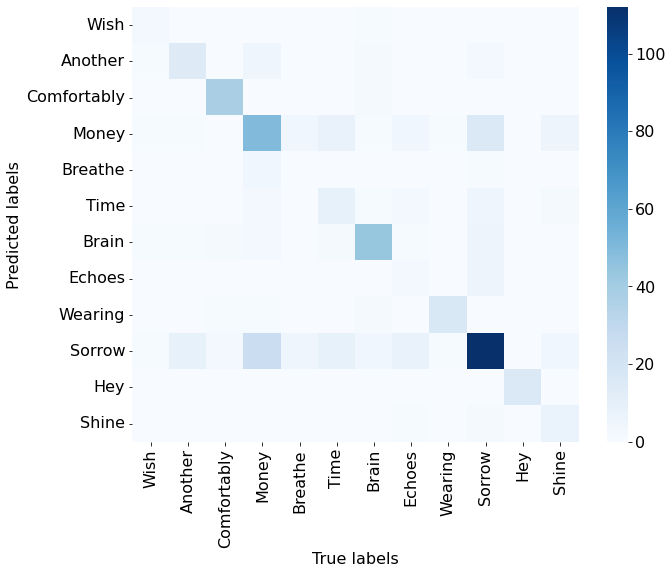

In [ ]:
# Compute the confusion matrix on the validation set
predictions = lstm_synth.predict(X_val_aug)
cm = confusion_matrix(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
lstm_synth.save("lstm_synth")

In [ ]:
x_aug = X.copy()
y_aug = y.copy()
x_aug, X_val_aug, y_aug, y_val_aug = train_test_split(x_aug, y_aug, test_size=0.2, random_state=seed*3121)
#Create new data from noise for training and validation (since the are very few samples for some classes)
for i in range(12):
    
    if i==0 or i==4 or i==11:
    #if i!=9 and i!=2 and i!=3 and i!=6 :

        #consider the class i samples and make j times new augmented data
        x_temp = x_aug[np.where(y_aug==i)[0],:,:]

        for j in range(1):
            x_temp = create_from_noise(x_temp)
            

            x_aug = np.append(x_aug, x_temp, axis=0)
            #append the labels of the class i
            y_aug = np.append(y_aug,np.array([[i] for k in range(len(x_temp[:,0,0]))]))
y_aug = tfk.utils.to_categorical(y_aug)
y_val_aug = tfk.utils.to_categorical(y_val_aug)

In [ ]:
cnn_low_synth2 = build_1DCNN_classifier2((36,6),classes)

In [ ]:
# Train the model
# cnn_low_filters_synth = build_1DCNN_classifier2(input_shape, classes)
history = cnn_low_synth2.fit(
    x = x_aug,
    y = y_aug,
    batch_size = batch_size,
    epochs = 500,
    validation_data = (X_val_aug, y_val_aug),
    class_weight = weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=100, factor=0.5, min_lr=1e-4)
    ]
).history

16/16 [==============================] - 0s 3ms/step
Accuracy: 0.6728
Precision: 0.6601
Recall: 0.6046
F1: 0.6049


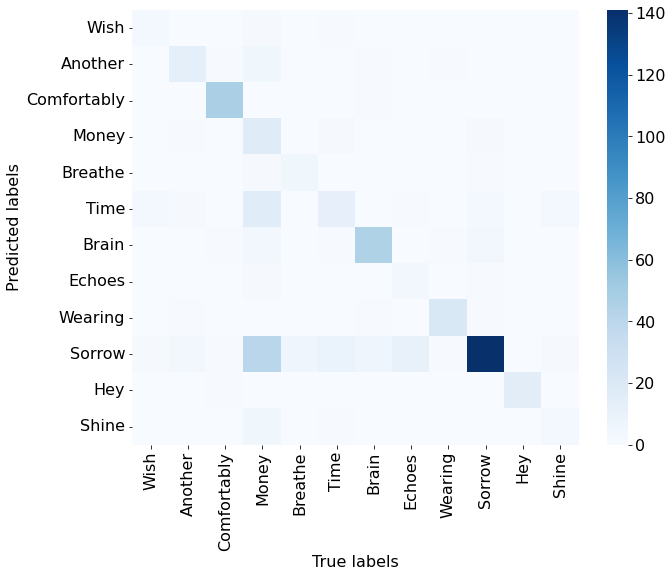

In [ ]:
# Compute the confusion matrix on the validation set
predictions = cnn_low_synth2.predict(X_val_aug)
cm = confusion_matrix(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_aug, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
cnn_low_synth2.save("cnn_low_filters_synth2")

cnn with cws and dilation time on normal data +
cnn 128 avg pool 256 filters on synth data +
cnn 16 32 64 filters on synth data + convlstm synth


In [ ]:
cnn1 = tfk.models.load_model("cnn_synth_7265")
cnn2 = tfk.models.load_model("cnn_low_filters_synth2")
# cnn3 = tfk.models.load_model("cnnbest_dil_cws7163")
convlstm = tfk.models.load_model("convlstm_synth")
lstm = tfk.models.load_model("lstm_synth")

In [ ]:
# cnnbest._name = "cnn1"
cnn1._name = "cnn1"
cnn2._name = "cnn2"
lstm._name = "lstm"
convlstm._name = "convlstm"

In [ ]:
models = []
models.append(cnn1)
models.append(cnn2)
models.append(lstm)
models.append(convlstm)

In [ ]:
cnn1 = tfk.models.load_model("cnn_synth_7265")
cnn2 = tfk.models.load_model("cnn_low_filters_synth")
cnn3 = tfk.models.load_model("cnnbest_dil_cws7163")
convlstm = tfk.models.load_model("convlstm_synth")

In [ ]:
# cnnbest._name = "cnn1"
cnn1._name = "cnn1"
cnn2._name = "cnn2"
cnn3._name = "cnn3"
convlstm._name = "convlstm"

In [ ]:
models = []
models.append(cnn1)
models.append(cnn2)
models.append(cnn3)
models.append(convlstm)

In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=tfk.layers.average(yModels) 
    # build model from same input and avg output
    modelEns = tfk.Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [ ]:
model_input = tfk.Input(shape=models[0].input_shape[1:]) 
modelEns = ensembleModels(models, model_input)
modelEns.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
modelEns.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 cnn1 (Functional)              (None, 12)           151948      ['input_1[0][0]']                
                                                                                                  
 cnn2 (Functional)              (None, 12)           34460       ['input_1[0][0]']                
                                                                                                  
 lstm (Functional)              (None, 12)           235276      ['input_1[0][0]']                
                                                                                           

In [ ]:
modelEns.save("16_12_2cnn_lstm_convlstm_synth")

In [ ]:
# modelEns.save("3CNNs")

####Ensemble models with "soft" class weights

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed*10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed*11)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed*12)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed*13)#
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed*14)

In [ ]:
from sklearn.utils import class_weight
cws = class_weight.compute_class_weight(class_weight = "balanced" , classes = np.unique(y_train), y= y_train)

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

In [ ]:
weights = {i : cws[i] for i in range(12)}

In [ ]:
#lower weights
for i in range(12):
  weights[i]=1
  if(i!=2 and i!= 3 and i!= 6 and i!=9):
    weights[i]=2
  if(i==9):
    weights[i]=0.5

In [ ]:
weights

{0: 2, 1: 2, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 0.5, 10: 2, 11: 2}

In [ ]:
# model = build_LSTM_classifier(input_shape,classes)
model = build_1DCNN_classifier(input_shape,classes)
# model = build_1DCNN_classifier2(input_shape,classes)
# model = build_1DCNN_classifier3(input_shape,classes)
# model = build_CONV_LSTM_model(input_shape,classes)

In [ ]:
# Train the model with class weights
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 400,
    validation_data = (X_val,y_val),
    class_weight = weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 400,
    validation_data = (X_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
# Predict the val set with the BiLSTM
predictions = model.predict(X_val)

16/16 [==============================] - 0s 2ms/step


In [ ]:
lstm = tfk.models.load_model("lstm_13_12")
convlstm = tfk.models.load_model("17_12_cws_convlstm")
# convlstm = tfk.models.load_model("ConvBilstm_13_12")
cnn1 = tfk.models.load_model("cnn74_14_12")
cnn2 = tfk.models.load_model("17_12_cws_conv2")
cnn3 = tfk.models.load_model("17_12_cws_conv3")

In [ ]:
cnn1._name = "cnn1"
cnn2._name = "cnn2"
cnn3._name = "cnn3"
lstm._name = 'lstm'
convlstm._name = 'convlstm'

In [ ]:
models = []

models.append(cnn1)
models.append(cnn2)
models.append(cnn3)
models.append(convlstm)
models.append(lstm)

In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=tfk.layers.average(yModels) 
    # build model from same input and avg output
    modelEns = tfk.Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [ ]:
model_input = tfk.Input(shape=models[0].input_shape[1:]) 
modelEns = ensembleModels(models,model_input)
modelEns.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
modelEns.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 cnn1 (Functional)              (None, 12)           151948      ['input_1[0][0]']                
                                                                                                  
 cnn2 (Functional)              (None, 12)           34460       ['input_1[0][0]']                
                                                                                                  
 cnn3 (Functional)              (None, 12)           151948      ['input_1[0][0]']                
                                                                                           

In [ ]:
modelEns.save("ABC")

#####Bagging 5 CNNs

In [ ]:
# Accuracy: 0.7202
# Precision: 0.7498
# Recall: 0.5464
# F1: 0.5908
def build_1DCNN_classifier1(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(16,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(32,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(cnn)

    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
cnn1 = build_1DCNN_classifier1(input_shape, classes)
# cnn1.summary()

In [ ]:
# Accuracy: 0.7407
# Precision: 0.7124
# Recall: 0.6806
# F1: 0.6735
def build_1DCNN_classifier2(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.AveragePooling1D()(cnn)# 
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
cnn2 = build_1DCNN_classifier2(input_shape, classes)
# cnn2.summary()

In [ ]:

def build_1DCNN_classifier3(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,dilation_rate = 2,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(256,3,dilation_rate = 2,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
cnn3 = build_1DCNN_classifier3(input_shape, classes)
# cnn3.summary()

In [ ]:
def build_1DCNN_classifier4(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(16,5,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(32,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)

    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
cnn4 = build_1DCNN_classifier4(input_shape, classes)
# cnn4.summary()

In [ ]:
# Accuracy: 0.7284
# Precision: 0.6541
# Recall: 0.549
# F1: 0.5787
def build_1DCNN_classifier5(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.AveragePooling1D(pool_size = 6)(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)

    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
cnn5 = build_1DCNN_classifier5(input_shape, classes)
# cnn5.summary()

In [ ]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.1, random_state=seed+1)
y_train1 = tfk.utils.to_categorical(y_train1)
y_val1 = tfk.utils.to_categorical(y_val1)
# Train the model
history = cnn1.fit(
    x = X_train1,
    y = y_train1,
    batch_size = batch_size,
    epochs = 200,
    validation_data= (X_val1,y_val1),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

In [ ]:
predictions = cnn1.predict(X_val1)
accuracy = accuracy_score(np.argmax(y_val1, axis=-1), np.argmax(predictions, axis=-1))
print(accuracy)

8/8 [==============================] - 0s 2ms/step
0.720164609053498


In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.1, random_state=seed+2)
y_train2 = tfk.utils.to_categorical(y_train2)
y_val2 = tfk.utils.to_categorical(y_val2)
# Train the model
history = cnn2.fit(
    x = X_train2,
    y = y_train2,
    batch_size = batch_size,
    epochs = 200,
    validation_data= (X_val2,y_val2),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

In [ ]:
predictions = cnn2.predict(X_val2)
accuracy = accuracy_score(np.argmax(y_val2, axis=-1), np.argmax(predictions, axis=-1))
print(accuracy)

8/8 [==============================] - 0s 2ms/step
0.6872427983539094


In [ ]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X, y, test_size=0.1, random_state=seed+3)
y_train3 = tfk.utils.to_categorical(y_train3)
y_val3 = tfk.utils.to_categorical(y_val3)
# Train the model
history = cnn3.fit(
    x = X_train3,
    y = y_train3,
    batch_size = batch_size,
    epochs = 300,
    validation_data= (X_val3,y_val3),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

In [ ]:
np.max(history["val_accuracy"])

0.7078189253807068

In [ ]:
predictions = cnn3.predict(X_val3)
accuracy = accuracy_score(np.argmax(y_val3, axis=-1), np.argmax(predictions, axis=-1))
print(accuracy)

8/8 [==============================] - 0s 2ms/step
0.7078189300411523


In [ ]:
X_train4, X_val4, y_train4, y_val4 = train_test_split(X, y, test_size=0.1, random_state=seed+4)
y_train4 = tfk.utils.to_categorical(y_train4)
y_val4 = tfk.utils.to_categorical(y_val4)
# Train the model
history = cnn4.fit(
    x = X_train4,
    y = y_train4,
    batch_size = batch_size,
    epochs = 200,
    validation_data= (X_val4,y_val4),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

In [ ]:
predictions = cnn4.predict(X_val4)
accuracy = accuracy_score(np.argmax(y_val4, axis=-1), np.argmax(predictions, axis=-1))
print(accuracy)

8/8 [==============================] - 0s 3ms/step
0.691358024691358


In [ ]:
X_train5, X_val5, y_train5, y_val5 = train_test_split(X, y, test_size=0.1, random_state=seed+5)
y_train5 = tfk.utils.to_categorical(y_train5)
y_val5 = tfk.utils.to_categorical(y_val5)
# Train the model
history = cnn5.fit(
    x = X_train5,
    y = y_train5,
    batch_size = batch_size,
    epochs = 200,
    validation_data= (X_val5,y_val5),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-4)
    ]
).history

In [ ]:
predictions = cnn5.predict(X_val5)
accuracy = accuracy_score(np.argmax(y_val5, axis=-1), np.argmax(predictions, axis=-1))
print(accuracy)

8/8 [==============================] - 0s 2ms/step
0.7283950617283951


In [ ]:
# Compute the confusion matrix on the validation set
predictions = convlstm1.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
cnn1._name = "cnn1"
cnn2._name = "cnn2"
cnn3._name = "cnn3"
cnn4._name = "cnn4"
cnn5._name = "cnn5"

In [ ]:
models = []

models.append(cnn1)
models.append(cnn2)
models.append(cnn3)
models.append(cnn4)
models.append(cnn5)

In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=tfk.layers.average(yModels) 
    # build model from same input and avg output
    modelEns = tfk.Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [ ]:
model_input = tfk.Input(shape=models[0].input_shape[1:]) 
modelEns = ensembleModels(models,model_input)
modelEns.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
modelEns.summary()

In [ ]:
# modelEns.save("5cnns_13_12")